# Pytrans examples: a surface trap

This example shows how to generate a basic quadratic potential.

The model used here is SufaceTrap, as an example of a trap model defined from analytical functions. It uses a subset of the eletrodes of the LioniX surface trap used in Cryo (2020 - 2022). 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from functools import partial

In [3]:
from pytrans import objectives as obj
from pytrans.solver import solver

from pytrans.analysis import analyse_potential
from models.surface_trap.plot import plot_voltages_on_trap

from pytrans.ions import Ca40, elementary_charge
from pytrans.conversion import freq_to_curv, curv_to_freq

freq_to_curv = partial(freq_to_curv, mass=Ca40.mass, charge=elementary_charge)
curv_to_freq = partial(curv_to_freq, mass=Ca40.mass, charge=elementary_charge)


Loading interpolators: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]


In [4]:
from models.surface_trap import SurfaceTrap
trap = SurfaceTrap()

r0 = (0, 0, 70e-6)

# Analyse the pseudopotential

--------------
Analyse curvatures along trajectory: 


100%|██████████| 81/81 [00:09<00:00,  8.78it/s]


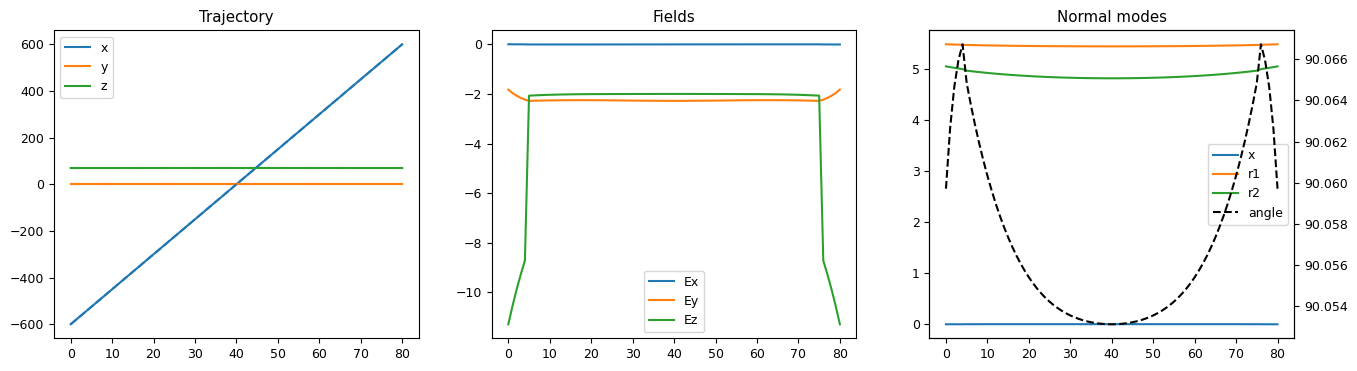

In [5]:
HH = trap.pseudo_hessian(*r0)
curv_to_freq(HH)

from pytrans.analysis import analyse_fields_curvatures

_ = analyse_fields_curvatures(trap, voltages=np.zeros((trap.n_electrodes,)), find_3dmin=True, x=trap.x[::30])

--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 15.000 ms
Potential mimimum [um]
[9.28182948e-02 1.02211689e-02 7.11285446e+01]
Gradient [V/m]
[   0.30570385    4.55177949 -106.98670714]
Hessian [V/m2]
[[ 3.29334457e+06  1.36026332e+00  1.97181635e+03]
 [ 1.36026332e+00  4.45320445e+08 -2.00751756e+05]
 [ 1.97181635e+03 -2.00751756e+05  4.05779057e+08]]
Normal mode frequencies for Ca40 [MHz]
[0.448789 5.21868 4.98159]
Eigenvectors
[[1 1.96e-08 -4.9e-06]
 [-5.3e-09 -1 -0.00508]
 [-4.9e-06 0.00508 -1]]
Tilt angle of mode 2 (4.98): 89.71°



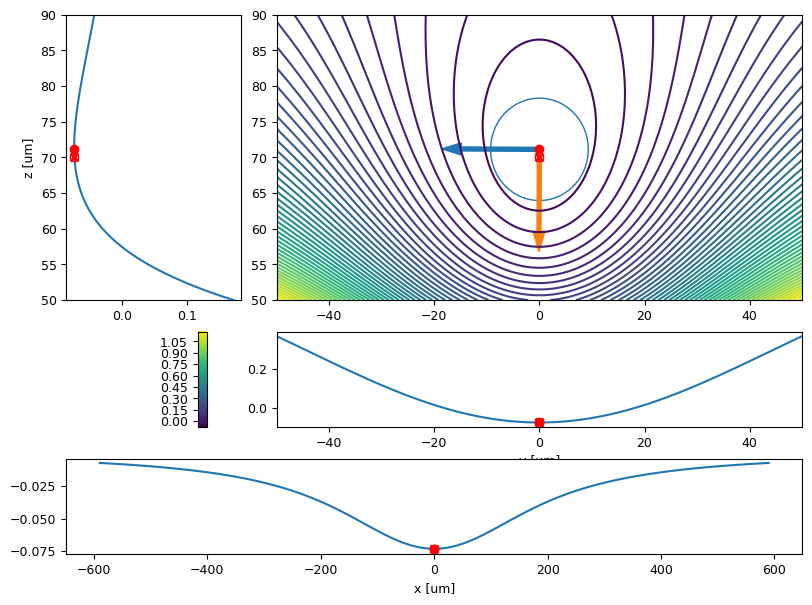

In [6]:
trap1 = SurfaceTrap(electrodes=["DCtop3", "DCbot3"])
trap1.v_rf = 40
trap1.rf_freq = 20
trap1.ion = Ca40
res = analyse_potential(trap1, voltages=[-1, -1], r0=(0, 0, 70e-6), pseudo=True, find_3dmin=True, roi=(800, 50, 20))

## Let's fit the usual quadratic potential

In [7]:
import cvxpy as cx

(12,) [-3.09797404e-03 -3.09800184e-03  1.51414733e+00 -4.30546642e+00
  1.21086658e+00  6.65467776e-01  2.18129458e-01  1.51414734e+00
 -4.30546640e+00  1.21086655e+00  6.65467758e-01  2.18129424e-01]
[]
(1, 12)
(12,)
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 155.106 ms
Potential mimimum [um]
[-1.65054237e+02 -4.51855530e-03  7.35733910e+01]
Gradient [V/m]
[-0.56514066 -1.64864437 -5.29353288]
Hessian [V/m2]
[[1.69708333e+07 6.68352652e+01 1.87100824e+05]
 [6.68352652e+01 3.64861931e+08 7.97638282e+04]
 [1.87100824e+05 7.97638282e+04 2.68000906e+08]]
Normal mode frequencies for Ca40 [MHz]
[1.01876 4.72376 4.04848]
Eigenvectors
[[1 -6.35e-07 -0.000745]
 [-2.12e-08 -1 0.000823]
 [-0.000745 -0.000823 -1]]
Tilt angle of mode 2 (4.05): 90.05°



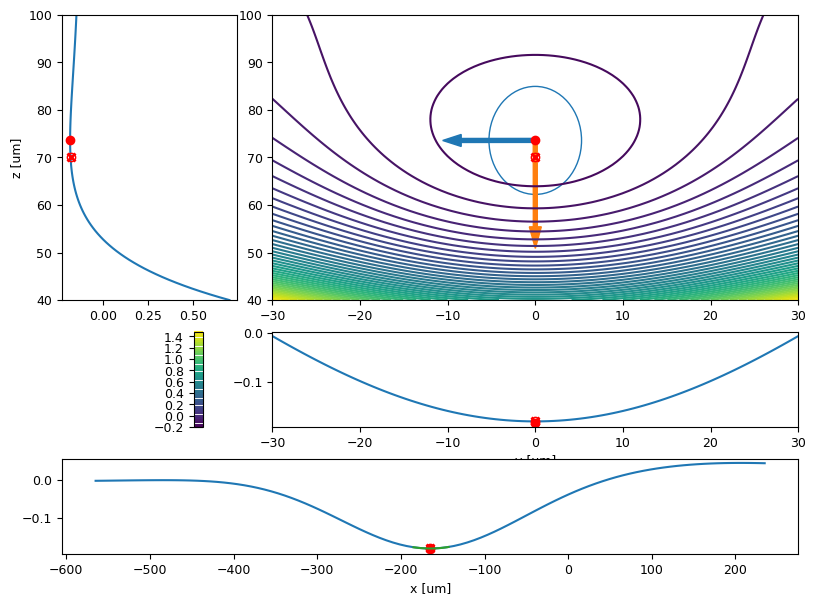

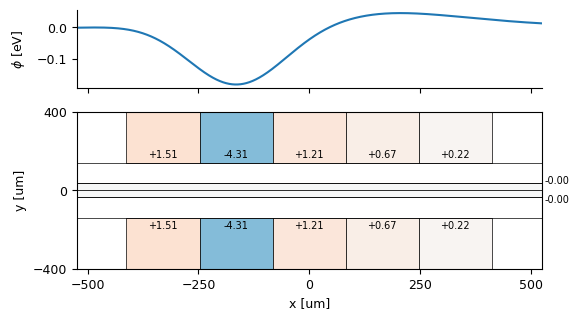

In [33]:
trap = SurfaceTrap()
# trap.v_rf = 40
# trap.rf_freq = 20
# trap.ion = Ca40

freq = 1e6
x0 = trap.x_ele(2)
y0 = 0
z0 = 70e-6

# offset = -2
# TRICK: leave the offset to the optimizer by defining it as a Variable
offset = cx.Variable()
offset.value = 0

R = 20e-6
dx = 2e-6
x = np.arange(-R, R + dx, dx) + x0
curv = freq_to_curv(freq)
pot = 0.5 * curv * (x - x0)**2 + offset

# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [obj.PotentialObjective(x, y=0, z=trap.z0, value=pot)]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     offset >= -0.3
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value
print(voltages.shape)

voltages = voltages[0]  # let's just take the one sample
print(voltages.shape)

res = analyse_potential(trap, voltages, (x0, y0, z0), find_3dmin=True)
_pot = 0.5 * curv * (x - x0)**2 + offset.value
res['axes'][0].plot(x * 1e6, _pot)

_ = plot_voltages_on_trap(trap, voltages)


## Let's try with the new trap model with Electrodes

--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 18.003 ms
Potential mimimum [um]
[9.28182948e-02 1.02211689e-02 7.11285446e+01]
Gradient [V/m]
[   0.30570385    4.55177949 -106.98670714]
Hessian [V/m2]
[[ 3.29334457e+06  1.36026332e+00  1.97181635e+03]
 [ 1.36026332e+00  4.45320445e+08 -2.00751756e+05]
 [ 1.97181635e+03 -2.00751756e+05  4.05779057e+08]]
Normal mode frequencies for Ca40 [MHz]
[0.448789 5.21868 4.98159]
Eigenvectors
[[1 1.96e-08 -4.9e-06]
 [-5.3e-09 -1 -0.00508]
 [-4.9e-06 0.00508 -1]]
Tilt angle of mode 2 (4.98): 89.71°



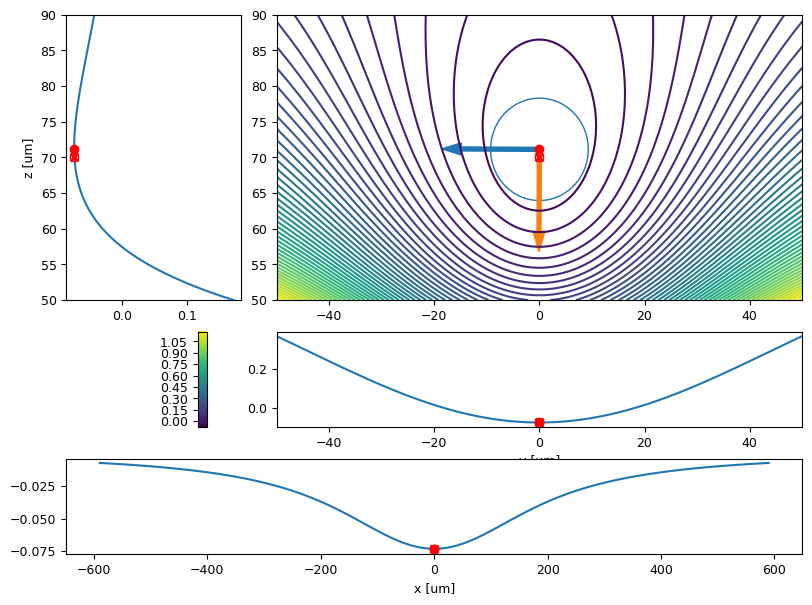

In [39]:
from models.surface_trap.model_electrodes import SurfaceTrap as SurfaceTrapWithElectrodes

trap_el = SurfaceTrapWithElectrodes(use_electrodes=["DCtop3", "DCbot3"])
res = analyse_potential(trap_el, voltages=[-1, -1], r0=(0, 0, 70e-6), pseudo=True, find_3dmin=True, roi=(800, 50, 20))


(12,) [-0.40244349 -0.40244349  1.50518718 -4.22628793  1.23565075  0.66945632
  0.01091362  1.50518718 -4.22628793  1.23565075  0.66945632  0.01091362]
[]
(1, 12)
(12,)
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 324.019 ms
Potential mimimum [um]
[-1.65000002e+02 -2.65888280e-07  6.99999997e+01]
Gradient [V/m]
[-0.0000225  -0.00012431 -0.00011213]
Hessian [V/m2]
[[1.63512921e+07 3.28433884e-03 1.33175819e+05]
 [3.28433884e-03 4.67519739e+08 5.77081878e+00]
 [1.33175819e+05 5.77081878e+00 3.37997378e+08]]
Normal mode frequencies for Ca40 [MHz]
[0.999998 5.34717 4.54654]
Eigenvectors
[[1 -2.04e-11 -0.000414]
 [-1.98e-12 -1 4.46e-08]
 [-0.000414 -4.46e-08 -1]]
Tilt angle of mode 2 (4.55): 90.00°



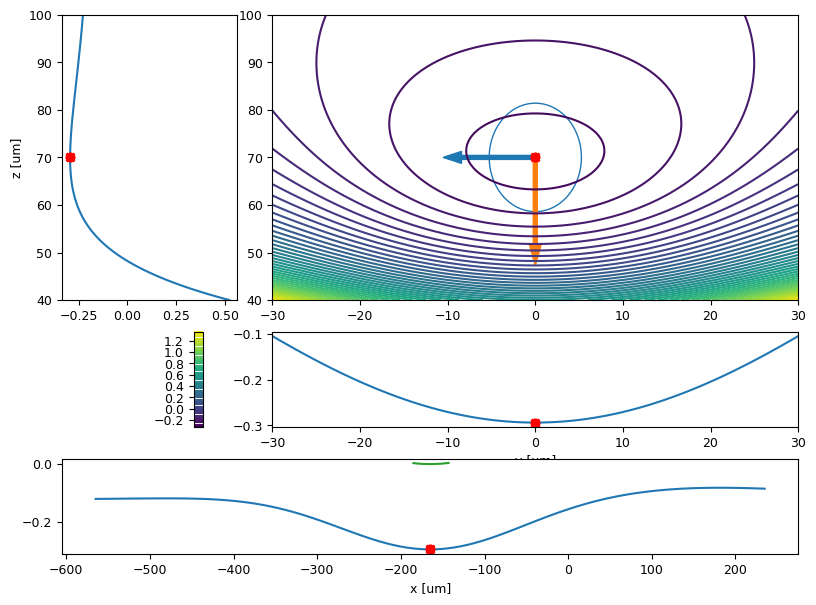

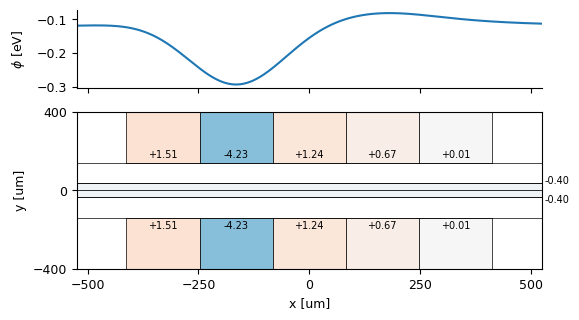

In [43]:
from models.surface_trap.model_electrodes import SurfaceTrap as SurfaceTrapWithElectrodes

trap = SurfaceTrapWithElectrodes()
# trap.v_rf = 40
# trap.rf_freq = 20
# trap.ion = Ca40

freq = 1e6
x0 = trap.x_ele(2)
y0 = 0
z0 = 70e-6

# offset = -2
# TRICK: leave the offset to the optimizer by defining it as a Variable
offset = cx.Variable()
offset.value = 0

R = 20e-6
dx = 2e-6
x = np.arange(-R, R + dx, dx) + x0
curv = freq_to_curv(freq)
pot = 0.5 * curv * (x - x0)**2 + offset

# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
# step_objectives = [
#     [obj.PotentialObjective(x, y=0, z=trap.z0, value=pot)]
# ]

step_objectives = [
    [
        obj.GradientObjective(x0, y0, z0, 0),
        obj.HessianObjective(x0, y0, z0, axial, entries=["xx"]),
        # # obj.HessianObjective(x0, y0, z0, rtilt, entries=["yz"]),
        # obj.HessianObjective(x0, y0, z0, curv.ravel(), pseudo=False),
    ]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     offset >= -0.3
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value
print(voltages.shape)

voltages = voltages[0]  # let's just take the one sample
print(voltages.shape)

res = analyse_potential(trap, voltages, (x0, y0, z0), find_3dmin=True)
_pot = 0.5 * curv * (x - x0)**2 + offset.value
res['axes'][0].plot(x * 1e6, _pot)

_ = plot_voltages_on_trap(trap, voltages)


## Fit 3D
Here I'd like to build the ellipsoid that has the axial and radial curvatures that I want.
Without radial mode rotation (a.k.a. tilt) is easy. I do think it's possible also with tilt but not quite sure how now.

(12,) [ 1.15848737  5.8388371   9.99999928  9.99999973  8.09431534  9.99999973
  9.99999928  6.36799907  9.99999947 -1.89551984  9.99999947  6.36799907]
[]
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 88.011 ms
Potential mimimum [um]
[-5.77746009e-02  2.46784620e+00  6.43726581e+01]
Gradient [V/m]
[-0.76093131  7.20563892 -8.84712912]
Hessian [V/m2]
[[ 1.31697218e+07  1.54586215e+04 -4.11692472e+03]
 [ 1.54586215e+04  3.89263278e+08  2.07759153e+08]
 [-4.11692472e+03  2.07759153e+08  1.26117934e+09]]
Normal mode frequencies for Ca40 [MHz]
[0.897454 4.57531 8.94444]
Eigenvectors
[[1 -4.86e-05 -4.68e-07]
 [-4.73e-05 -0.975 0.221]
 [1.12e-05 0.221 0.975]]
Tilt angle of mode 2 (8.94): 77.26°



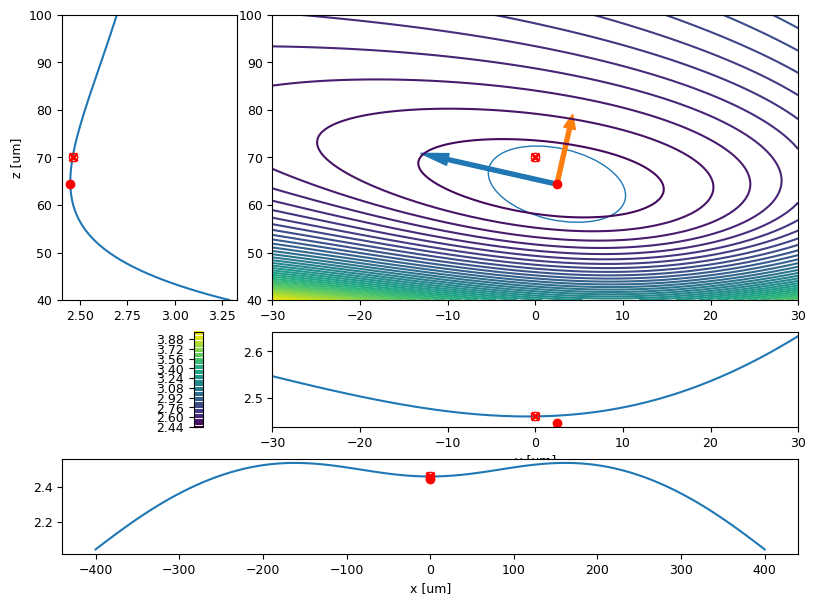

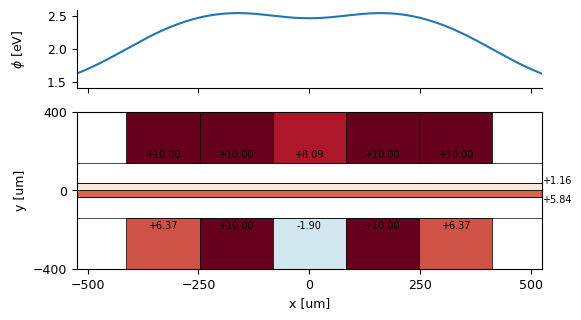

In [9]:
# I'll just guess some frequencies that I know are reasonable for this trap, since it's basically a subset of the Cryo one
axial = freq_to_curv(1e6)
r1 = freq_to_curv(3.5e6)
r2 = freq_to_curv(6.5e6)


x0 = 0

# TRICK: leave the offset floating by letting the optimizer vary it
offset = cx.Variable()
offset.value = 0
# offset = 0

x = np.arange(-30, 32, 4) * 1e-6
y = np.arange(-20, 21, 2) * 1e-6
z = np.arange(-20, 21, 2) * 1e-6  # don't put z0 here

curv = np.diag([axial, r1, r2])  # .astype(object)

# rtilt = cx.Variable()
# rtilt.value = freq_to_curv(2e6)
rtilt = 2e8
curv[1, 2] = curv[2, 1] = rtilt

# There must be a more elegant way than meshgrid + ravel + stack
# But it works so let's go for it
R = np.meshgrid(x, y, z, indexing='ij')  # First axis is X, Y, Z. please always use ij with 3d data
R = np.stack(list(map(np.ravel, R)), axis=0)
X, Y, Z = R

pot = 0.5 * np.diag(R.T @ curv @ R) + offset
pot.shape


# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [obj.PotentialObjective(X, Y, Z + trap.z0, pot)]
]

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     r2 >= freq_to_curv(2e6)
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value[0]  # let's just take the one sample

res = analyse_potential(trap, voltages, (x0, y0, z0))
_ = plot_voltages_on_trap(trap, voltages)


# Opt hessian matrix

(12,) [-1.11625355 -0.03521078  4.20577918 -5.85776323  3.83775178  1.70181094
  0.54395971 -1.99667903 -3.09347942 -1.6024985  -1.95310221 -0.08176222]
[]
--------------
Analyse potential: 
Exec minimize
- minimize elapsed time: 317.594 ms
Potential mimimum [um]
[-1.65000003e+02 -4.28176527e-07  6.99999995e+01]
Gradient [V/m]
[-0.00004303 -0.00023122 -0.00019096]
Hessian [V/m2]
[[ 1.63513799e+07 -6.36378095e-01 -5.05831087e+04]
 [-6.36378095e-01  4.79807201e+08  5.00000104e+07]
 [-5.05831087e+04  5.00000104e+07  3.29816105e+08]]
Normal mode frequencies for Ca40 [MHz]
[1 5.50178 4.38688]
Eigenvectors
[[1 3.06e-05 0.000162]
 [-1.77e-05 -0.957 0.29]
 [0.000164 -0.29 -0.957]]
Tilt angle of mode 2 (4.39): 106.85°



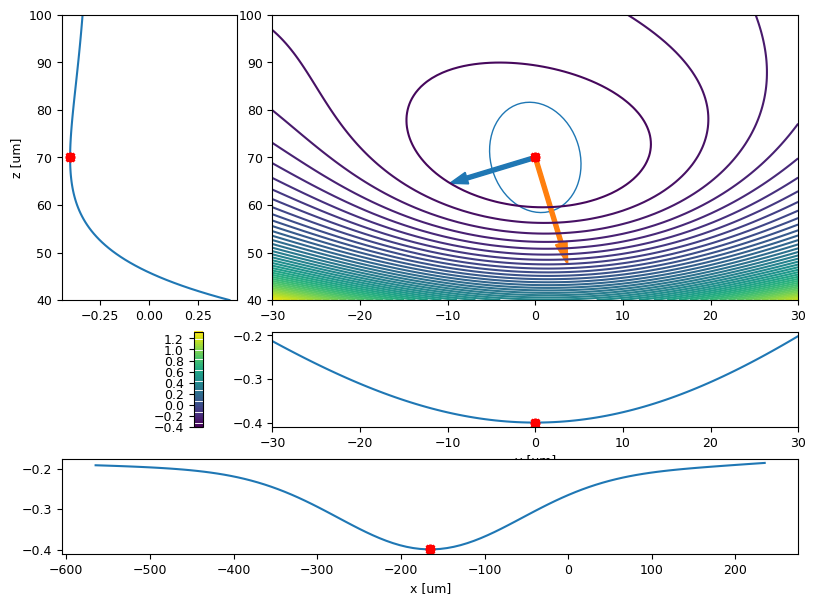

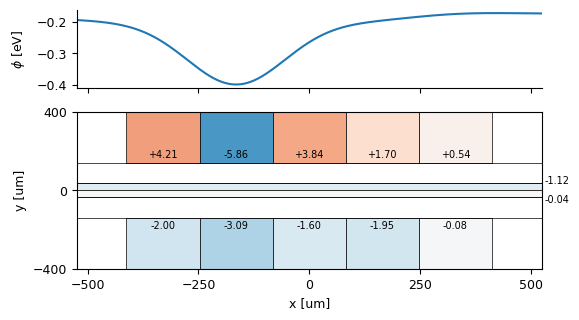

In [10]:
# I'll just guess some frequencies that I know are reasonable for this trap, since it's basically a subset of the Cryo one
axial = freq_to_curv(1e6)
# r1 = freq_to_curv(3.5e6)
# r2 = freq_to_curv(6.5e6)
r1 = -axial / 2
r2 = -axial / 2 

x0 = trap.x_ele(2)

curv = np.diag([axial, r1, r2])  # .astype(object)

# rtilt = cx.Variable()
# rtilt.value = freq_to_curv(2e6)
rtilt = 5e7
curv[1, 2] = curv[2, 1] = rtilt



# len(step_opjectives) == number of steps == number of samples in the final waveform
# each element is a list of minimization objectives for that step
step_objectives = [
    [
        obj.GradientObjective(x0, y0, z0, 0),
        # obj.HessianObjective(x0, y0, z0, axial, entries=["xx"]),
        # obj.HessianObjective(x0, y0, z0, rtilt, entries=["yz"]),
        obj.HessianObjective(x0, y0, z0, curv.ravel(), pseudo=False),
    ]
]
# for dx in [20e-6, 50e-6, 100e-6]:
#     step_objectives[0].extend(
#         [
#             obj.HessianObjective(x0 + dx, y0, z0, axial, entries=["xx"]),
#             obj.HessianObjective(x0 - dx, y0, z0, axial, entries=["xx"]),
#         ]
#     )

global_objectives = [
    obj.VoltageObjective(10, constraint_type='<='),
    obj.VoltageObjective(-10, constraint_type='>=')
]

# extra_constraints = [
#     r2 >= freq_to_curv(2e6)
# ]
extra_constraints = None
waveform, final_costs = solver(trap, step_objectives, global_objectives, extra_constraints, verbose=False)
print(waveform[0].shape, waveform[0].value)
pprint(final_costs)

voltages = waveform.value[0]  # let's just take the one sample


res = analyse_potential(trap, voltages, (x0, y0, z0))
_ = plot_voltages_on_trap(trap, voltages)


In [11]:
curv

array([[16351292.16831272,        0.        ,        0.        ],
       [       0.        , -8175646.08415636, 50000000.        ],
       [       0.        , 50000000.        , -8175646.08415636]])

In [12]:
a = np.ones((2, 4))

aa = np.ones(10)

In [13]:
e1 = np.asarray([a, a, a])
e2 = np.stack([a, a, a], axis=-1)

e1.shape, e2.shape

((3, 2, 4), (2, 4, 3))

In [14]:
h1 = np.asarray([[a, a, a], [a, a, a], [a, a, a]])
h2 = h1.transpose(tuple(_ for _ in range(2, h1.ndim)) + (0, 1))
h1.shape, h2.shape

((3, 3, 2, 4), (2, 4, 3, 3))

In [15]:
tuple(_ for _ in range(2, h1.ndim)) + (0, 1)


(2, 3, 0, 1)

In [16]:
a.ndim

2

In [17]:
from models.surface_trap.data.analytic import hessiansDC

In [18]:
# Compute hessians in a 2d plane


x = 0
y = np.linspace(-20, 21, 4) * 1e-6
z = np.linspace(-20, 21, 6) * 1e-6  + 70e-6

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
X.shape

(1, 4, 6)

In [19]:
HH = hessiansDC.DCtop3(X, Y, Z)

In [20]:
HH.shape

(1, 4, 6, 3, 3)

In [21]:
trap = SurfaceTrap()

HHint = trap.electrode_moment("DCtop3", X, Y, Z, d=2)

In [22]:
abs(HH).min()

0.0

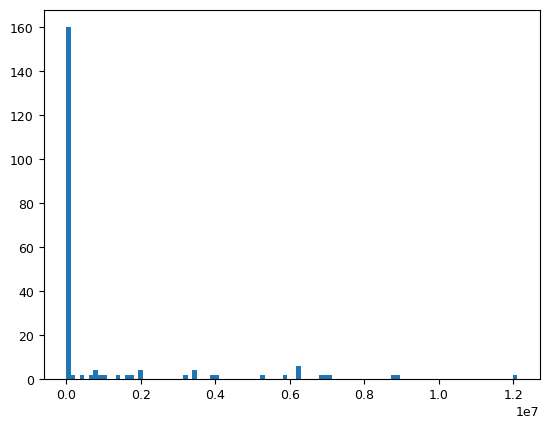

In [23]:
rdiff = (abs(HH - HHint) / np.maximum(abs(HH), 1e-12)).ravel()

_ = plt.hist(rdiff, 100)


In [24]:
np.allclose(hessiansDC.DCtop3(*r0), trap.electrode_moment("DCtop3", *r0, d=2), rtol=1)


True